In [25]:
# Module imports
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

import sys
import re
import os

from postprocessingutils import eval_stats_reader

In [26]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=28)
plt.rc('font', size=35)
plt.rc('legend', fontsize=22)               # Make the legend/label fonts 
plt.rc('xtick', labelsize=23)               # a little smaller
plt.rc('ytick', labelsize=23)

mrk_size = 12

In [27]:
# Experiment
ex = {"timestamp" : 1672737751, "nb_env" : 1, "nb_episodes" : 0,
      "dt" : 0.007, "act_freq": 80//4, "nb_interactions" : 3000, "n_agents" : 16, 
      "resolution" : 64, "ctrl_amp" : 0.04285714285714286,
      "ckpt_step" : 6144000, "nb_init" : 6,
      "description" : r"DDPG MinChan, scaled_inputs with u_\tau"}

loading = False

In [28]:
# Parameters
nx = ex["resolution"]
ny = 65
nz = ex["resolution"]
retau = 180
Re_cl = 2100
nu = 1/Re_cl

baseline_dudy_dict = {"180_16x65x16"   : 3.7398798426242075,
                      "180_32x33x32"   : 3.909412638928125,
                      "180_32x65x32"   : 4.325313533321045,
                      "180_64x65x64"   : 3.82829465265046,
                      "180_128x65x128" : 3.82829465265046}
baseline_dudy = baseline_dudy_dict[f"{int(retau)}_" + \
                             f"{nx}x{ny}x{nz}"]

u_tau = np.sqrt(nu*baseline_dudy)
Re_tau = 2*u_tau/nu
tstar = nu/u_tau**2

In [29]:
# Baseline and opposition control
# Baseline params
tstamp_opp = 101
res_bsl = ex['resolution']

with np.load(f"../runs/{tstamp_opp}/re_hist_bsl{res_bsl}.npz",allow_pickle=True) as f:
        re_bsl = f['re_p_hist']

# Opposition params
tstamp_opp = 100
res_opp = ex['resolution']

# Adding opposition
with np.load(f"../runs/{tstamp_opp}/re_hist_opp{res_opp}.npz",allow_pickle=True) as f:
        re_opp = f['re_p_hist']

rew_opp = (1-(re_opp[:,1]/re_bsl[:,1])**2)
rew_opp_avg = np.mean(rew_opp*100,axis=0)
rew_opp_std = np.std(rew_opp*100,axis=0)

In [30]:
# Checkpoints to evaluate
n_ckpti=46
n_ckpt=46

if ex["resolution"]==16:
    ckpt_list = [ex["ckpt_step"]*i for i in range(n_ckpti,n_ckpt+1)]
if ex["resolution"]==64:
    ckpt_list = [ex["ckpt_step"]*i+64 for i in range(n_ckpti,n_ckpt+1)]

In [ ]:
if loading:
    for ckpt in ckpt_list:
        print(ckpt)
        main_file = "main_1.out"
        re_hist_ = eval_stats_reader(ex,main_file,evaluation=True,ckpt=ckpt)

        np.savez(f"../runs/{ex['timestamp']}/re_hist_{ckpt}.npz",re_hist=re_hist_)

Average reduction, opposition: 19.98113772335623
Average reduction, DRL: 30.75592453651652


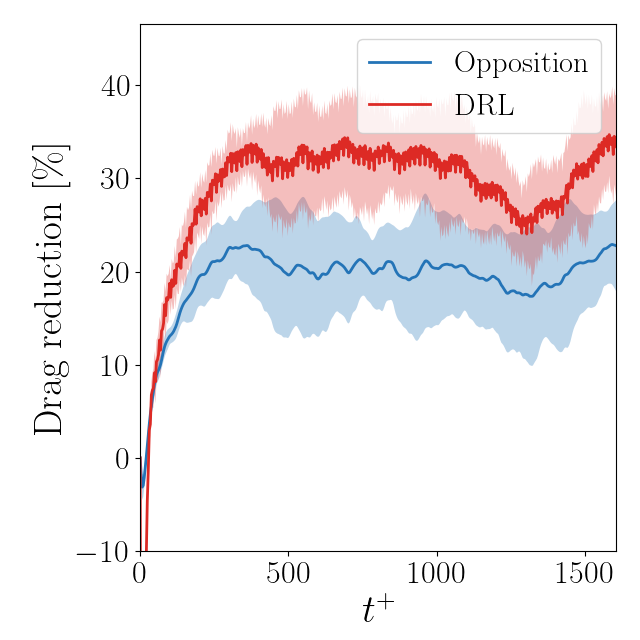

In [32]:
%matplotlib widget

# Make sure you choose the appropriate checkpoint
ckpt = ckpt_list[-1]
with np.load(f"../runs/{ex['timestamp']}/re_hist_{ckpt}.npz",allow_pickle=True) as f:
        re_hist = f['re_hist']

fig_comp = plt.figure(2,figsize=[6.4, 6.4])
ax_comp = fig_comp.add_subplot(111)
ax_comp.set(xlabel=r"$t^+$", ylabel='Drag reduction [\%]')

p0_baseline = ax_comp.fill_between((re_opp[0,0]-np.floor(re_opp[0,0,0]))/tstar,
                               rew_opp_avg-rew_opp_std,
                               rew_opp_avg+rew_opp_std,
                               alpha=0.3,facecolor=[0.14260669, 0.45633218, 0.71660131, 1.])

p1_baseline = ax_comp.plot((re_opp[0,0]-np.floor(re_opp[0,0,0]))/tstar,
                       rew_opp_avg,
                       label='Opposition',linewidth=2,color=[0.14260669, 0.45633218, 0.71660131, 1.])


re_epavg_ckpt = np.mean(re_hist[:,1]*2,axis=1)
rewckpt_ = (1-(re_epavg_ckpt/Re_tau)**2)

rew = (1-(re_hist[:,1]/re_bsl[:,1])**2)
rew_baseline_avg = np.mean(rew*100,axis=0)
rew_baseline_std = np.std(rew*100,axis=0)

if re_hist.shape[0]>1:
      p0_baseline = ax_comp.fill_between((re_opp[0,0]-np.floor(re_opp[0,0,0]))/tstar,
                                      rew_baseline_avg-rew_baseline_std,
                                      rew_baseline_avg+rew_baseline_std,
                                      alpha=0.3,facecolor=[0.86805075, 0.16409073, 0.14371396, 1.])
p1_baseline = ax_comp.plot((re_opp[0,0]-np.floor(re_opp[0,0,0]))/tstar,
                        rew_baseline_avg,
                        label="DRL",linewidth=2,color=[0.86805075, 0.16409073, 0.14371396, 1.])

ax_comp.legend()
ax_comp.set(ylim=[-10,ax_comp.get_ylim()[1]],
            xlim=[0,
                  (re_opp[0,0,-1]-np.floor(re_opp[0,0,0]))/tstar])
print(f"Average reduction, opposition: {np.mean(rew_opp_avg[127:])}")
print(f"Average reduction, DRL: {np.mean(rew_baseline_avg[127:])}")
fig_comp.tight_layout()
plt.subplots_adjust(top=0.963,
bottom=0.139,
left=0.219,
right=0.963,
hspace=0.2,
wspace=0.2)